In [ ]:
#| default_exp colors

In [ ]:
#| export
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from fastcore.all import *
from PIL import Image

In [ ]:
img_path = Path('../images/image3.png')
img = Image.open(img_path).convert("RGB")

## 3D color representaion

In [ ]:
#| export
def extract_colors(img):
    arr = np.array(img)/255 # normalize to unit cube
    cols  = arr.reshape(-1, 3)
    return cols.T

<mpl_toolkits.mplot3d.art3d.Path3DCollection>

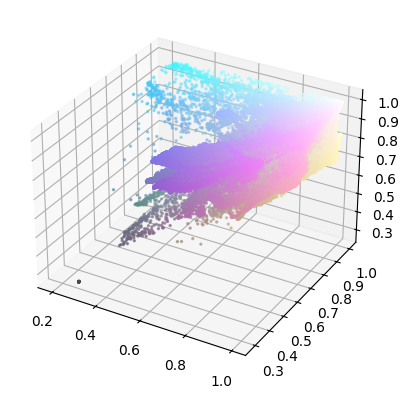

In [ ]:
cols = extract_colors(img)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*cols, c = cols.T, s=2)

In [ ]:
#| export
def scatter_plotly(cols):
    x,y,z = cols
    return go.Figure(data=[go.Scatter3d(x=x,y=y,z=z, mode='markers', marker=dict(size=2, color=cols.T))])

def compress_img(img, scale=256):
    w, h = img.size
    return img.resize((min(scale,w), min(scale,h)))

In [ ]:
# scatter_plotly(extract_colors(compress_img(img, 256)))

# K-means clustering

In [ ]:
def k_means(points, k=5, eps=1e-4):
    centroids = points[np.random.choice(points.shape[0], k, replace=False)]
    
    while True:
        clusters = np.argmin(((points - centroids[:,None])**2).sum(axis=-1), 0) 
        new_centroids = np.array([points[clusters == i].mean(axis=0) for i in range(k)])
        if np.all(np.abs(new_centroids - centroids) < eps):
            break
        centroids = new_centroids
    
    return clusters, centroids

def segment_k_means(img, k=5, eps=1e-2):
    img = np.array(img)/255
    points = img.reshape(-1,  img.shape[-1])
    clusters, centroids = k_means(points, k, eps)
    points = centroids[clusters]
    return Image.fromarray(np.uint8(points.reshape(img.shape)*255))

In [ ]:
# res = segment_k_means(img, 88)

In [ ]:
#| export
import torch

def k_means(points, k=5, eps=1e-4):
    centers = points.unique(dim=0)
    centroids = centers[torch.randperm(centers.size(0))[:k]]
    
    while True:
        clusters = torch.argmin(torch.cdist(points, centroids), dim=1)
        new_centroids = torch.stack([points[clusters == i].mean(dim=0) for i in range(k)])
        if torch.all(torch.abs(new_centroids - centroids) < eps):
            break
        centroids = new_centroids
    
    return clusters, centroids

def segment_k_means(img, k=5, eps=1e-2):
    points = img.reshape(-1, img.shape[-1])
    clusters, centroids = k_means(points, k, eps)
    points = centroids[clusters].reshape(img.shape)
    return Image.fromarray((points*255).type(torch.uint8).cpu().numpy())

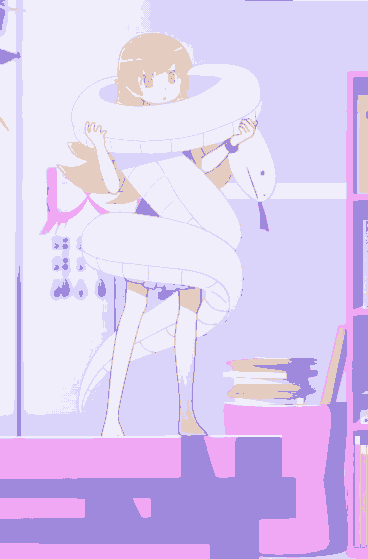

In [ ]:
i = torch.tensor(np.array(img), dtype=torch.float32) / 255
i = i.to('cuda')
segment_k_means(i, 5)

In [ ]:
from nbdev import export

export.nb_export('colors.ipynb', '.')